## 환경 변수에서 API 키를 가져옵니다.

In [1]:
# 환경 변수에서 API 키 가져오기

import os
from urllib.parse import unquote

API_KEY = unquote(os.environ['ANIMAL_API_KEY'])
LOCATIONIQ_TOKEN = os.environ['LOCATIONIQ_TOKEN']

## 라이브러리 사용

In [2]:
# requests 사용

import requests
requests.__version__

'2.22.0'

In [3]:
# Pandas 사용

import pandas as pd
pd.__version__

'0.25.0'

In [4]:
# Matplotlib 사용

import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.1.1'

In [5]:
# matplotlib에 “AppleGothc”(Mac) 또는 “Malgun Gothic”(Windows) 글꼴 적용

import matplotlib.font_manager as fm

for font in fm.fontManager.ttflist:
    if font.name in ['AppleGothic', 'Malgun Gothic']:
        plt.rcParams['font.family'] = font.name
        break

plt.rcParams['font.family']

['Malgun Gothic']

In [6]:
# folium 패키지 설치

!pip install folium

In [9]:
# folium 버전 확인

import folium
folium.__version__

'0.10.0'

In [10]:
# folium 라이브러리의 Map과 HeatMap 사용

from folium import Map
from folium.plugins import HeatMap

## 동물보호관리시스템 유기동물 조회 서비스 API 사용

많은 데이터를 다루기 위해 한꺼번에 만 개를 얻어오겠습니다.

In [11]:
# 동물보호관리시스템 유기동물 조회 서비스 API
# 원래 URL: http://openapi.animal.go.kr/.../abandonmentPublic?serviceKey=어쩌고&bgnde=20190901&...
# 이렇게 긴 URL을 물음표(?)를 기준으로 두 부분으로 나눕니다.
# 물음표(?) 앞부분
url = 'http://openapi.animal.go.kr/openapi/service/rest/abandonmentPublicSrvc/abandonmentPublic'

# 물음표(?) 뒷부분
payload = {
    'serviceKey': API_KEY,
    'bgnde': '20190901',
    'endde': '20190930',
    'numOfRows': 10_000,
}

# API 호출
response = requests.get(url, params=payload)
print(response)

<Response [200]>


In [12]:
# Response의 Text 길이 확인

len(response.text)

7376418

In [13]:
# XML 데이터 파싱
# ElementTree는 파이썬의 lterator를 활용함

import xml.etree.ElementTree as ET

root = ET.fromstring(response.text)
root

<Element 'response' at 0x0CBD1150>

In [14]:
# 첫번째 내용을 얻고 다음으로 넘어갑니다.
item = next(root.iter('item'))

# Item에 어떤 내용이 있는지 확인합니다.
list(item)

[<Element 'age' at 0x0CBD1DB0>,
 <Element 'careAddr' at 0x0CBD1DE0>,
 <Element 'careNm' at 0x0CBD1E10>,
 <Element 'careTel' at 0x0CBD1E40>,
 <Element 'chargeNm' at 0x0CBD1E70>,
 <Element 'colorCd' at 0x0CBD1EA0>,
 <Element 'desertionNo' at 0x0CBD1F00>,
 <Element 'filename' at 0x0CBD1F30>,
 <Element 'happenDt' at 0x0CBD1F60>,
 <Element 'happenPlace' at 0x0CBD1F90>,
 <Element 'kindCd' at 0x0CBD1FC0>,
 <Element 'neuterYn' at 0x0CBDC030>,
 <Element 'noticeEdt' at 0x0CBDC060>,
 <Element 'noticeNo' at 0x0CBDC090>,
 <Element 'noticeSdt' at 0x0CBDC0C0>,
 <Element 'officetel' at 0x0CBDC0F0>,
 <Element 'orgNm' at 0x0CBDC120>,
 <Element 'popfile' at 0x0CBDC150>,
 <Element 'processState' at 0x0CBDC180>,
 <Element 'sexCd' at 0x0CBDC1B0>,
 <Element 'specialMark' at 0x0CBDC1E0>,
 <Element 'weight' at 0x0CBDC240>]

In [17]:
# <kindCd> 항목을 확인해 봅니다.
# 트리에서 바로 아래에 있는 걸 “자녀”라고 부릅니다.

child = item.find('kindCd')
print(child)

<Element 'kindCd' at 0x0CBD1FC0>


In [18]:
# 자녀의 내용(text)을 확인해 봅니다.
print(child.text)

[개] 푸들


In [19]:
# 이게 뭐였죠?
print(child.tag)

kindCd


XML은 key와 value를 다루는데 유용합니다.
파이썬의 Dictionary와 같죠.

데이터:

```text
이름: 홍길동
나이: 13세
```

파이썬:

```python
{
    'name': '홍길동',
    'age:' 13
}
```

XML:

```xml
<person>
    <name>홍길동</name>
    <age>13</age>
</person>
```

`person`, `name`, `age` 등이 태그(tag)에 해당합니다.

In [20]:
# item의 모든 자녀 확인

for child in item:
    print(child.tag, child.text)

age 2016(년생)
careAddr 경상남도 고성군 고성읍 송학리 260-54
careNm 백호종합동물병원
careTel 010-3551-8261
chargeNm 이주영
colorCd 흰색
desertionNo 448542201900419
filename http://www.animal.go.kr/files/shelter/2019/09/201909241409108_s.jpg
happenDt 20190924
happenPlace 경남 고성군 영오면 양산4길 12
kindCd [개] 푸들
neuterYn N
noticeEdt 20191008
noticeNo 경남-고성-2019-00332
noticeSdt 20190924
officetel 055-670-4314
orgNm 경상남도 고성군
popfile http://www.animal.go.kr/files/shelter/2019/09/201909241409108.jpg
processState 보호중
sexCd M
specialMark 피모 불량
weight 5(Kg)


태그만 모아서 컬럼으로 활용합시다.

In [21]:
# 컬럼 목록 얻기

item = next(root.iter('item'))

columns = []
for child in item:
    columns.append(child.tag)

columns

['age',
 'careAddr',
 'careNm',
 'careTel',
 'chargeNm',
 'colorCd',
 'desertionNo',
 'filename',
 'happenDt',
 'happenPlace',
 'kindCd',
 'neuterYn',
 'noticeEdt',
 'noticeNo',
 'noticeSdt',
 'officetel',
 'orgNm',
 'popfile',
 'processState',
 'sexCd',
 'specialMark',
 'weight']

In [23]:
# XML 데이터를 Pandas DataFrame으로 변환

# dictionary의 list를 준비합니다. 처음엔 0개죠.
rows = []

# item을 하나씩 rows에 넣을 겁니다.
for item in root.iter('item'):
    # 일단 row를 준비합니다. 단수형과 복수형을 구분해서 쓰니까 주의하세요.
    row = {}
    # item의 자녀를 하나씩 row에 넣을 겁니다.
    # 이런 코드가 나오면 앞에 나온 for는 잊어버리세요.
    # 지금부터 나오는 것에 집중하세요.
    for child in list(item):
        # dictionary는 key와 value를 함께 써서 추가 또는 변경합니다.
        # tag와 text가 헷갈리면 바로 위에 나온 ElementTree를 다시 확인하세요.
        # tag와 text는 보편적인 표현이 아닙니다.
        # A라는 폴더의 README.md 파일과 B라는 폴더의 README.md 파일은 이름이 같지만 전혀 다릅니다.
        # 어떤 게 들어있는지는 직접 열어보기 전에는 알 수 없습니다.
        # “모르는 것 발견 = 지금 당장 확인”을 습관으로 만드세요. 손은 눈보다 빠릅니다.
        row[child.tag] = child.text
    # 이렇게 블록이 끝나면 방금 있던 for를 잊으세요.
    # 우리가 얻은 건 item의 자녀 내용이 들어간 row죠.
    # 이제 이걸 rows(단수형과 복수형에 주의하세요)에 넣어줍니다.
    # list는 append를 썼죠?
    rows.append(row)

# dictionary의 list는 Pandas의 DataFrame으로 쉽게 변경 가능합니다.

df = pd.DataFrame(rows, columns=columns)

In [24]:
# 1. 컬럼 목록

df.columns

Index(['age', 'careAddr', 'careNm', 'careTel', 'chargeNm', 'colorCd',
       'desertionNo', 'filename', 'happenDt', 'happenPlace', 'kindCd',
       'neuterYn', 'noticeEdt', 'noticeNo', 'noticeSdt', 'officetel', 'orgNm',
       'popfile', 'processState', 'sexCd', 'specialMark', 'weight'],
      dtype='object')

In [25]:
# 2. 전체 갯수와 컬럼 갯수 확인
df.shape

(9413, 22)

In [26]:
# 3. 데이터 일부 확인
df.head()

,age,careAddr,careNm,careTel,chargeNm,colorCd,desertionNo,filename,happenDt,happenPlace,...,noticeEdt,noticeNo,noticeSdt,officetel,orgNm,popfile,processState,sexCd,specialMark,weight
0,2016(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,010-3551-8261,이주영,흰색,448542201900419,http://www.animal.go.kr/files/shelter/2019/09/...,20190924,경남 고성군 영오면 양산4길 12,...,20191008,경남-고성-2019-00332,20190924,055-670-4314,경상남도 고성군,http://www.animal.go.kr/files/shelter/2019/09/...,보호중,M,피모 불량,5(Kg)
1,2017(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,010-3551-8261,이주영,흰갈색,448542201900416,http://www.animal.go.kr/files/shelter/2019/09/...,20190924,경남 고성군 하이면 월흥7길 11-3,...,20191008,경남-고성-2019-00331,20190924,055-670-4314,경상남도 고성군,http://www.animal.go.kr/files/shelter/2019/09/...,보호중,M,특이사항 없음,6(Kg)
2,2019(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,010-3551-8261,이주영,고동색,448542201900415,http://www.animal.go.kr/files/shelter/2019/09/...,20190924,경남 고성군 고성읍 수남2길 39,...,20191008,경남-고성-2019-00330,20190924,055-670-4314,경상남도 고성군,http://www.animal.go.kr/files/shelter/2019/09/...,보호중,M,특이사항 없음,4(Kg)
3,2019(년생),경상남도 의령군 의령읍 의병로9동길 30 (의령읍) 의령군농업기술센터,전조동,055-570-4150,의령군,흰색,448539201900058,http://www.animal.go.kr/files/shelter/2019/09/...,20190924,경남 의령군 용덕면 가락마을부근,...,20191004,경남-의령-2019-00061,20190924,055-570-4153,경상남도 의령군,http://www.animal.go.kr/files/shelter/2019/09/...,보호중,F,"사람 잘따름,많이 작은 사이즈",4(Kg)
4,2019(년생),경상남도 의령군 의령읍 의병로9동길 30 (의령읍) 의령군농업기술센터,전조동,055-570-4150,의령군,"검정,흰색갈색모색",448539201900057,http://www.animal.go.kr/files/shelter/2019/09/...,20190924,경남 의령군 용덕면 가락마을부근,...,20191004,경남-의령-2019-00060,20190924,055-570-4153,경상남도 의령군,http://www.animal.go.kr/files/shelter/2019/09/...,보호중,F,암컷강아지 두마리,4(Kg)


In [27]:
# 컬럼별 결측값 갯수 확인

data = df.isnull().sum()

pd.DataFrame(data)

,0
age,0
careAddr,0
careNm,0
careTel,0
chargeNm,207
colorCd,0
desertionNo,0
filename,0
happenDt,0
happenPlace,0


In [28]:
# 안 쓰는 컬럼 이름을 넣어 drop해서 simple 데이터 만들기

simple_df = df.drop(columns=[
    'careTel', 'desertionNo', 'filename',
    'noticeEdt', 'noticeNo', 'noticeSdt', 'officetel', 'popfile'
])

# 정리된 데이터 확인
simple_df.head()

,age,careAddr,careNm,chargeNm,colorCd,happenDt,happenPlace,kindCd,neuterYn,orgNm,processState,sexCd,specialMark,weight
0,2016(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,이주영,흰색,20190924,경남 고성군 영오면 양산4길 12,[개] 푸들,N,경상남도 고성군,보호중,M,피모 불량,5(Kg)
1,2017(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,이주영,흰갈색,20190924,경남 고성군 하이면 월흥7길 11-3,[개] 믹스견,N,경상남도 고성군,보호중,M,특이사항 없음,6(Kg)
2,2019(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,이주영,고동색,20190924,경남 고성군 고성읍 수남2길 39,[개] 믹스견,N,경상남도 고성군,보호중,M,특이사항 없음,4(Kg)
3,2019(년생),경상남도 의령군 의령읍 의병로9동길 30 (의령읍) 의령군농업기술센터,전조동,의령군,흰색,20190924,경남 의령군 용덕면 가락마을부근,[개] 믹스견,U,경상남도 의령군,보호중,F,"사람 잘따름,많이 작은 사이즈",4(Kg)
4,2019(년생),경상남도 의령군 의령읍 의병로9동길 30 (의령읍) 의령군농업기술센터,전조동,의령군,"검정,흰색갈색모색",20190924,경남 의령군 용덕면 가락마을부근,[개] 믹스견,U,경상남도 의령군,보호중,F,암컷강아지 두마리,4(Kg)


## 데이터 살펴보기

In [29]:
# 갯수 세기

data = simple_df['age'].value_counts()
pd.DataFrame(data)

,age
2019(년생),4716
2018(년생),1175
2017(년생),1159
2016(년생),879
2014(년생),403
2015(년생),380
2013(년생),223
2009(년생),137
2012(년생),122
2011(년생),110


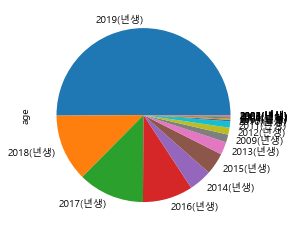

In [30]:
# 파이 그래프

data.plot.pie()
plt.show()

In [31]:
# 갯수 세기
data = simple_df['sexCd'].value_counts()
pd.DataFrame(data)

,sexCd
M,4409
F,4167
Q,837


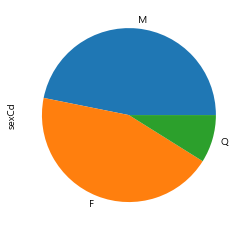

In [32]:
# 파이 그래프
data.plot.pie()
plt.show()

In [33]:
# 갯수 세기
data = simple_df['neuterYn'].value_counts()
pd.DataFrame(data)

,neuterYn
N,5956
U,3049
Y,408


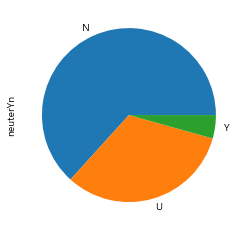

In [34]:
# 파이 그래프
data.plot.pie()
plt.show()

In [35]:
# 갯수 세기

data = simple_df['kindCd'].value_counts()
pd.DataFrame(data)

,kindCd
[개] 믹스견,4533
[고양이] 한국 고양이,2132
[개] 말티즈,435
[개] 푸들,380
[개] 진도견,236
[개] 포메라니안,164
[개] 시츄,121
[개] 요크셔 테리어,85
[개] 스피츠,78
[개] 치와와,72


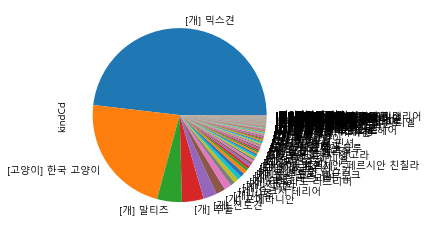

In [36]:
# 파이 그래프

data.plot.pie()
plt.show()

In [37]:
# 갯수 세기

data = simple_df['colorCd'].value_counts()
pd.DataFrame(data)

,colorCd
흰색,1728
갈색,913
검정,338
흰,283
삼색,169
검정색,142
백,136
황색,132
연갈색,125
갈,111


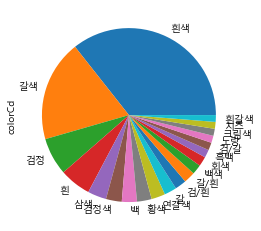

In [38]:
# 파이 그래프
# 데이터가 너무 많아서 20개로 제한
data = simple_df['colorCd'].value_counts().nlargest(20)
data.plot.pie()

plt.show()

In [34]:
# 갯수 세기

data = simple_df['happenDt'].value_counts()

pd.DataFrame(data)

,happenDt
20190916,789
20190902,661
20190909,619
20190918,609
20190917,572
20190920,526
20190910,522
20190911,521
20190919,507
20190905,504


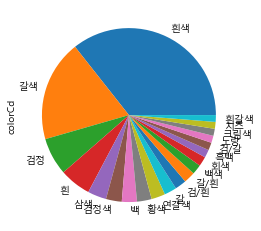

In [40]:
# 파이 그래프
data.plot.pie()
plt.show()

In [36]:
# 요일 구하기 (이 부분은 어렵습니다!)

DAYS = '일월화수목금토'

weekdays = []

for index in df.index:
    date = simple_df['happenDt'][index]
    # 2019년 9월 1일은 “일요일(0)”입니다.
    weekday = (int(date) - 20190901) % 7
    weekdays.append(DAYS[weekday])

simple_df = simple_df.assign(happenDay=weekdays)

simple_df.head()

,age,careAddr,careNm,chargeNm,colorCd,happenDt,happenPlace,kindCd,neuterYn,orgNm,processState,sexCd,specialMark,weight,happenDay
0,2017(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,이주영,흰갈색,20190924,경남 고성군 하이면 월흥7길 11-3,[개] 믹스견,N,경상남도 고성군,보호중,M,특이사항 없음,6(Kg),화
1,2019(년생),경상남도 고성군 고성읍 송학리 260-54,백호종합동물병원,이주영,고동색,20190924,경남 고성군 고성읍 수남2길 39,[개] 믹스견,N,경상남도 고성군,보호중,M,특이사항 없음,4(Kg),화
2,2014(년생),경상남도 양산시 동면 석산리 392 양산시농업기술센터,양산시유기동물보호소,양산시,검은색,20190924,상북면효충길28,[개] 믹스견,N,경상남도 양산시,보호중,F,검은색 새끼셋마리,6.4(Kg),화
3,2018(년생),경상남도 양산시 동면 석산리 392 양산시농업기술센터,양산시유기동물보호소,양산시,갈색,20190924,상북면석계두레축산,[개] 믹스견,U,경상남도 양산시,보호중,M,갈색,6.4(Kg),화
4,2017(년생),경상남도 양산시 동면 석산리 392 양산시농업기술센터,양산시유기동물보호소,양산시,갈색,20190924,상북면상삼1길,[개] 믹스견,U,경상남도 양산시,보호중,M,갈색,6.4(Kg),화


In [37]:
# 갯수 세기

data = simple_df['happenDay'].value_counts()

pd.DataFrame(data)

,happenDay
월,2472
화,1638
수,1602
목,1230
금,1084
토,614
일,604


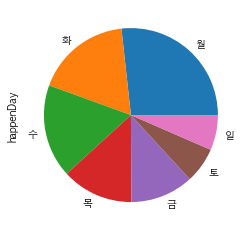

In [38]:
# 파이 그래프

data.plot.pie()

plt.show()

## 위도, 경도 얻기

반복적으로 써야 하니 함수를 만듭니다.

In [39]:
def geocode(address):
    url = 'https://us1.locationiq.com/v1/search.php'
    payload = {
        'key': LOCATIONIQ_TOKEN,
        'q': address,
        'format': 'json'
    }
    response = requests.get(url, params=payload)
    results = response.json()
    if 'error' in results:
        return None, None
    coordinates = results[0]
    return coordinates['lat'], coordinates['lon']

In [40]:
geocode('서울창업허브')

('37.54662875', '126.949684293519')

In [41]:
geocode('이 세계 어디에도 없는 주소')

(None, None)

In [42]:
# API 호출 및 지도에 표시하는 작업을 원활히 하기 위해 자료를 500개로 제한해서 sample 데이터를 만듭니다.

sample_df = simple_df.sample(n=500, random_state=1)

sample_df.shape

(500, 15)

In [43]:
# 위도, 경도 얻기

lats = []
lngs = []

for i, index in enumerate(sample_df.index):
    print(i + 1, '-', index)
    lat, lng = geocode(sample_df['orgNm'][index])
    lats.append(lat or 0)
    lngs.append(lng or 0)

sample_df = sample_df.assign(lat=lats, lng=lngs)

sample_df.head()

1 - 4804
2 - 9160
3 - 2021
4 - 2294
5 - 3680
6 - 6246
7 - 1094
8 - 6717
9 - 1103
10 - 6432
11 - 3497
12 - 5513
13 - 288
14 - 5819
15 - 1273
16 - 5774
17 - 5048
18 - 5016
19 - 3798
20 - 1178
21 - 8926
22 - 1821
23 - 5460
24 - 4687
25 - 613
26 - 4032
27 - 4880
28 - 1289
29 - 7327
30 - 7958
31 - 481
32 - 1840
33 - 4211
34 - 1851
35 - 4315
36 - 8060
37 - 2065
38 - 8153
39 - 4653
40 - 444
41 - 7459
42 - 3471
43 - 5023
44 - 1532
45 - 2012
46 - 5232
47 - 1545
48 - 2201
49 - 2488
50 - 763
51 - 3455
52 - 8433
53 - 3850
54 - 4853
55 - 822
56 - 3119
57 - 7278
58 - 7292
59 - 7795
60 - 161
61 - 6115
62 - 4477
63 - 5066
64 - 4987
65 - 4282
66 - 956
67 - 4286
68 - 9113
69 - 8916
70 - 8009
71 - 7593
72 - 8127
73 - 9183
74 - 5510
75 - 2711
76 - 6304
77 - 7093
78 - 834
79 - 1206
80 - 3724
81 - 3553
82 - 5734
83 - 7968
84 - 2263
85 - 2973
86 - 6417
87 - 3019
88 - 7366
89 - 8285
90 - 8026
91 - 3770
92 - 5488
93 - 3508
94 - 2358
95 - 82
96 - 8393
97 - 3938
98 - 8408
99 - 2827
100 - 8972
101 - 372
102 - 241

,age,careAddr,careNm,chargeNm,colorCd,happenDt,happenPlace,kindCd,neuterYn,orgNm,processState,sexCd,specialMark,weight,happenDay,lat,lng
4804,2019(년생),경상북도 포항시 북구 흥해읍 덕장길 224 (흥해읍),영일동물플러스,안창태,백검,20190911,경상북도 포항시 북구 신광면 사정리 과수원 인근,[개] 믹스견,N,경상북도 포항시,보호중,M,세마리 같이 구조 온순함,1(Kg),수,36.0189315,129.3429384
9160,2017(년생),강원도 원주시 호저면 칠봉로 110-6,원주유기동물보호센터,원주시,흰색,20190901,하나비바체근처,[개] 말티즈,N,강원도 원주시,종료(반환),F,앞머리 눈을 가림,2.8(Kg),일,37.3420996,127.9197603
2021,2019(년생),"경기도 고양시 덕양구 고양대로 1695 (원흥동, 고양시 농업기술센터) 고양시동물보호센터",고양시동물보호센터,김유미,"검정색, 흰색",20190918,삼송동345-1부근,[고양이] 한국 고양이,N,경기도 고양시,보호중,Q,꼬무리,0.2(Kg),수,37.6581862,126.8319452
2294,2019(년생),경기도 용인시 처인구 모현면 대지로 407 (모현면),죽전TNR동물병원,동물방역팀,노랑,20190918,광주시 오포읍 능평리 일대,[고양이] 한국 고양이,N,경기도 광주시,보호중,M,"9-65, 3주미만, 수유필요, 엄마가 되어주세요",0.20(Kg),수,37.39931825,127.292259889877
3680,2017(년생),경기도 안산시 상록구 청곡길 50 (부곡동),한국야생동물보호협회,안양시,백,20190916,시민대로 230 부근,[고양이] 페르시안-페르시안 친칠라,U,경기도 안양시,종료(반환),F,전체미용.,5(Kg),월,37.3938528,126.9570605


## 지도 그리기

위도/경도 데이터를 얻었기 때문에 지도에 그려볼 수 있습니다.

In [44]:
# 위도, 경도만 모읍니다.

coordinates = sample_df[['lat', 'lng']]

coordinates

,lat,lng
4804,36.0189315,129.3429384
9160,37.3420996,127.9197603
2021,37.6581862,126.8319452
2294,37.39931825,127.292259889877
3680,37.3938528,126.9570605
6246,35.1631,129.0529
1094,35.4355,126.7021
6717,36.58629,128.186793
1103,35.9679984,126.7369036
6432,35.5204145,127.7252966


In [45]:
# 지도 준비

map = Map(location=[36.5, 127.5], zoom_start=7)

# 지도에 위치 표시

for lat, lng in coordinates.values:
    marker = folium.Circle(
        location=[lat, lng],
        radius=5_000,
        weight=1,
        fill_color='#F00',
        fill_opacity=0.3,
    )
    marker.add_to(map)

map

In [46]:
# 지도 준비

map = Map(location=[36.5, 127.5], zoom_start=7)

# 히트맵 표시

HeatMap(data=coordinates, radius=20).add_to(map)

map